<a href="https://colab.research.google.com/github/revak18/nicotine_use_mathmodel/blob/main/NicotineUse_SIR_DDE_Model_with_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ddeint

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ddeint import ddeint

# Product type for simulation
product_type = 'EC'  # Change to 'C' for cigarettes

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006657  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12)  # Years to transition from youth to young adult
aging_rate_ya_to_a = 1 / (5 * 12)  # Years to transition from young adult to adult
tau_1, tau_2, tau_3 = 12, 6, 12  # Delays for infection, recovery, and relapse

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

# Function to generate linearly spaced integers
def linspace_integers(start, stop, num):
    """Generate a linearly spaced array of integers."""
    step = (stop - start) // (num - 1)  # Calculate step using integer division
    return np.arange(start, stop + step, step, dtype=int)

# Generate time points
t = linspace_integers(0, 419, 420)

# Function to calculate beta values - Infection
def beta_values(t):
    if product_type == 'EC':
        return 0.18 + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return 0.003 + (random.random() / 1000) * np.cos(t / 12 * np.pi)

# Function to calculate gamma values - Recovery
def gamma_values(t):
    if product_type == 'EC':
        return (1.333 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return (1.677 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)

# Function to calculate rho values - Relapse
def rho_values(t):
    if product_type == 'EC':
        return (1.600 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return (1.912 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)

# Calculate parameter arrays
beta = np.array([beta_values(t_i) for t_i in t])
gamma = np.array([gamma_values(t_i) for t_i in t])
rho = np.array([rho_values(t_i) for t_i in t])

if product_type == 'EC':
   print('E-Cigarettes')
else:
   print('Cigarettes')
# Output the first calculated value for beta, gamma, and rho for verification
print("First beta value:", beta[0])
print("First gamma value:", gamma[0])
print("First rho value:", rho[0])

E-Cigarettes
First beta value: 0.18639426798457884
First gamma value: 0.028386249589237703
First rho value: 0.043329720031018586


In [3]:
def model(Y, t):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
    else:
        S_y_delay = S_y
        I_y_delay = I_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
        I_ya_delay2 = Y(t - tau_2)[4]
        I_a_delay2 = Y(t - tau_2)[7]
    else:
        I_y_delay2 = I_y
        I_ya_delay2 = I_ya
        I_a_delay2 = I_a

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
        R_ya_delay3 = Y(t - tau_3)[5]
        R_a_delay3 = Y(t - tau_3)[8]
    else:
        R_y_delay3 = R_y
        R_ya_delay3 = R_ya
        R_a_delay3 = R_a

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_y_delay - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t] * S_ya * I_y_delay - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya_delay2 - (mu + rho[t]) * R_ya_delay3 - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a_delay2
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a_delay2 - (mu + rho[t]) * R_a_delay3

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    if product_type == 'EC':    # E-Cigarettes
       return [0.8000, 0.2000, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults as of 2022
    else:    # Cigarettes
       return [0.9170, 0.0830, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults as of 2022

# Solve DDE
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')
sol = ddeint(model, history, t)

totals = sol.sum(axis=1)
sol /= totals[:, None]

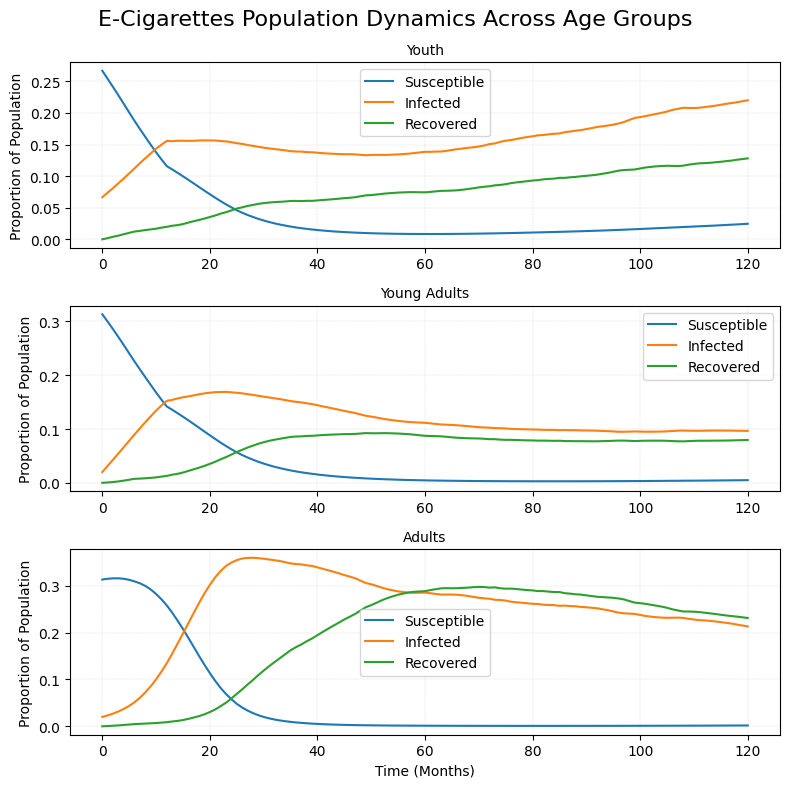

In [4]:
# Plotting results
plt.figure(figsize=(8, 8))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth', fontsize=10)
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults', fontsize=10)
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults', fontsize=10)
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.grid(color='gray', linestyle='dashed', linewidth=0.1)

if product_type == 'EC':    # E-Cigarettes
   stitle = 'E-Cigarettes Population Dynamics Across Age Groups'
else:                       # Cigarettes
   stitle = 'Cigarettes Population Dynamics Across Age Groups'
plt.suptitle(stitle, fontsize=16)
plt.tight_layout()
plt.show()